# Importing required libraries

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Paths for data import and result storage

In [7]:
dpath = r"/Users/bashirulazambiswas/Documents/Sadia/SUNY courses/2022_Fall/ICSI 518 Software Engineering/Project/Results/ML data/Station data"
path = r"/Users/bashirulazambiswas/Documents/Sadia/SUNY courses/2022_Fall/ICSI 518 Software Engineering/Project/Results/Classical time series models"

# Specification Selection

In [10]:
station_name = 'QUEE'
target_variable = 'temperature'
window = 5
train_method = 'prediction with target only'
model = "AR"


# Data preparation function

In [12]:
def data_prep(dpath, station_name,target_variable):
    data = classical_time_series_data(dpath,station_name,target_variable)
    data.time = time_coversion(data.time)
    return data

def classical_time_series_data(path,station_name,dependent_variable_label):
    data_preprocessed = preprocess(path,station_name,dependent_variable_label)
    if dependent_variable_label == 'temperature':
        dependent_variable = 'temp_2m_avg [degF]'
    elif dependent_variable_label == 'humidity':
        dependent_variable = 'relative_humidity_avg [percent]'
    elif dependent_variable_label == 'precipitation':
        dependent_variable = 'precip_total [inch]'    
    data_classical = data_preprocessed[0][['station','time',dependent_variable]]
    return data_classical


def time_coversion(time_col): #Converts time from string to datetime
    time_list = [time_col[i].split()[0] for i in range(len(time_col))]
    return pd.to_datetime(time_list)



# Preprocessing function

In [13]:
def preprocess(path,station_name,dependent_variable_label):
    data = pd.read_csv(path+"/"+station_name+".csv").drop("Unnamed: 0",axis=1)
    correlation = data.corr().round(2)
    index = correlation.index
    for i in correlation.index:
        if i in index:
            temp = correlation.loc[i]
            temp = temp[temp==1]
            for j in temp.index:
                if j != i:
                    if j not in index:
                        continue
                    index = index.drop(j)

    preprocessed_data = pd.DataFrame()
    preprocessed_data['station'] = data['station']               
    preprocessed_data['time'] = data['time']
    preprocessed_data[index] = data[index]
    

    if dependent_variable_label == 'temperature':
        dependent_variable = 'temp_2m_avg [degF]'
        independent_feature_label = preprocessed_data.columns.drop(['temp_2m_avg [degF]'])
    elif dependent_variable_label == 'humidity':
        dependent_variable = 'relative_humidity_avg [percent]'
        independent_feature_label = preprocessed_data.columns.drop(['relative_humidity_avg [percent]'])
    elif dependent_variable_label == 'precipitation':
        dependent_variable = 'precip_total [inch]'
        independent_feature_label = preprocessed_data.columns.drop(['precip_total [inch]'])
    x = preprocessed_data[independent_feature_label]
    y = preprocessed_data[dependent_variable]
    
    return preprocessed_data,x,y

### Data generated after preprocessing

In [21]:
data = data_prep(dpath, station_name,target_variable)
data.head(5)

,station,time,temp_2m_avg [degF]
0,QUEE,2018-09-10,59.7
1,QUEE,2018-09-11,67.9
2,QUEE,2018-09-12,72.6
3,QUEE,2018-09-13,70.8
4,QUEE,2018-09-14,70.7


# Train-test split function

In [15]:
def TrainTestSplit(data,target_variable):
    train_year = [2018,2019,2020]
    test_year = [2021,2022]
    if target_variable == 'temperature':
        target = 'temp_2m_avg [degF]'
    elif target_variable == 'humidity':
        target = 'relative_humidity_avg [percent]'
    elif target_variable == 'precipitation':
        target = 'precip_total [inch]'
    train = pd.DataFrame()
    for year in train_year:
         train = train.append(data[(data['time'].dt.year == year)])   
    train = train.drop(train[train[target].isna()].index)
    
    test = pd.DataFrame()
    for year in test_year:
         test = test.append(data[(data['time'].dt.year == year)]) 
    test = test.drop(test[test[target].isna()].index)
    return train,test

### Train and test set after splitting

In [28]:
train,test =  TrainTestSplit(data,target_variable)

print("Train:",train.shape)
print("Test:",test.shape)

Train: (822, 3)
Test: (618, 3)


# AutoRegression function

In [29]:
def AR_model(path,train,test,target_variable,p,d,q,station_name,model_name,train_method,seasonal_order=(0,0,0,0)):
    if target_variable == 'temperature':
        target = 'temp_2m_avg [degF]'
    elif target_variable == 'humidity':
        target = 'relative_humidity_avg [percent]'
    elif target_variable == 'precipitation':
        target = 'precip_total [inch]'
    model = AutoReg(train[target], lags=p)
    model_fit = model.fit()
    y_pred = model_fit.predict(1, len(test))
    prediction = pd.DataFrame({"time":test['time'].reset_index(drop=True),'predicted':y_pred.fillna(0).reset_index(drop=True),'actual':test[target].reset_index(drop=True)})
    return prediction






### Prediction using AutoRegression

In [32]:
prediction = AR_model(path,train,test,target_variable,window,0,0,station_name,model,train_method)

prediction.head(10)

,time,predicted,actual
0,2021-01-01,0.000000,36.0
1,2021-01-02,0.000000,42.1
2,2021-01-03,0.000000,35.7
3,2021-01-04,0.000000,37.3
4,2021-01-05,69.530999,37.7
5,2021-01-06,70.599991,36.4
6,2021-01-07,72.631817,34.5
7,2021-01-08,71.955456,31.2
8,2021-01-09,72.681099,30.7
9,2021-01-10,72.389429,33.6


# Plotting function

In [38]:
def PlotPrediction(prediction,target_variable,window,station_name,model_name,train_method):
    plt.figure(figsize=(20,10))
    plt.plot(prediction['time'],prediction['actual'],'--',label='actual')
    plt.plot(prediction['time'],prediction['predicted'],'-',label='prediction')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(target_variable)
    plt.title("Time series prediction of "+target_variable+" for the location "+station_name+" using "+model_name)
    

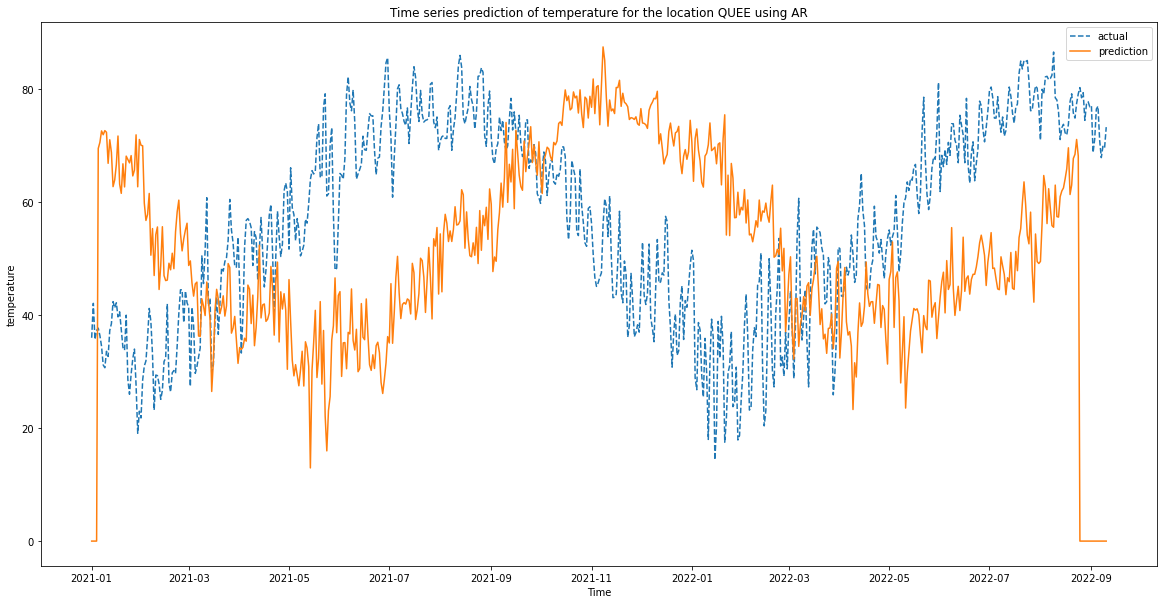

In [39]:
PlotPrediction(prediction,target_variable,window,station_name,model,train_method)